In [2]:
# 📦 Imports y Configuración
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-Learn
from sklearn.svm import SVC
from sklearn.datasets import make_moons, make_circles, make_blobs
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

# Configuración Visual
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

RANDOM_STATE = 42

---

## 2. La Intuición: Máximo Margen

### ¿Por Qué Maximizar el Margen?

Infinitos hiperplanos pueden separar dos clases. SVM elige el que tiene el **margen más grande**.

```
                    ✓ SVM (margen máximo)
    ●  ●           ─────────────────
    ●     ●        ═══════════════════  ← Margen
                   ─────────────────
         ○  ○  ○
           ○
```

### Matemáticamente

- **Hiperplano:** $\mathbf{w} \cdot \mathbf{x} + b = 0$
- **Margen:** $\frac{2}{||\mathbf{w}||}$
- **Objetivo:** Minimizar $||\mathbf{w}||^2$ sujeto a clasificar correctamente

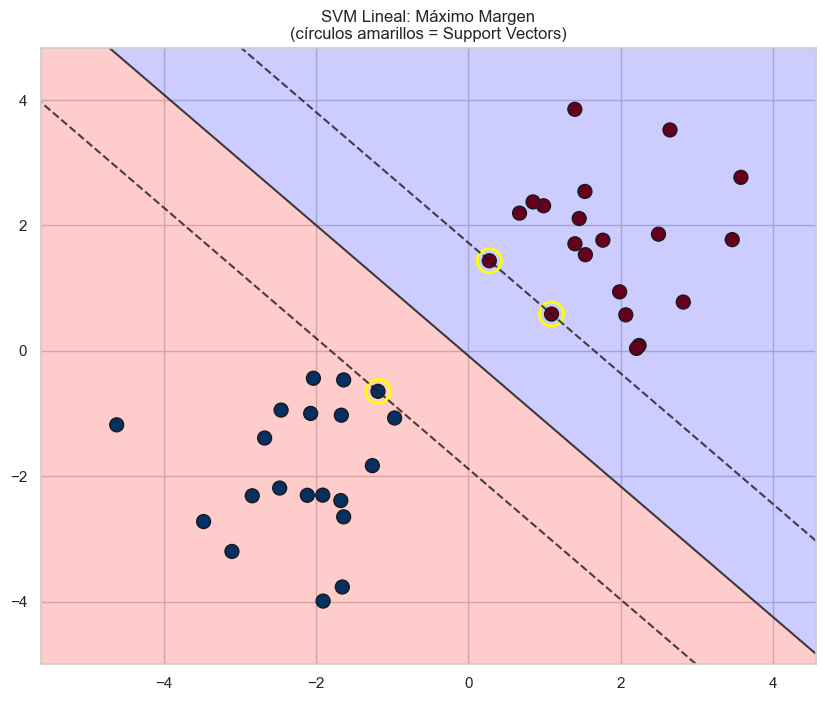

📊 Número de Support Vectors: 3
💡 Solo estos puntos definen la frontera. El resto es irrelevante.


In [3]:
# Visualización: Múltiples separadores vs SVM
np.random.seed(RANDOM_STATE)
X_simple = np.vstack([np.random.randn(20, 2) + [2, 2],
                      np.random.randn(20, 2) + [-2, -2]])
y_simple = np.array([0]*20 + [1]*20)

# Entrenar SVM lineal
svm_linear = SVC(kernel='linear', C=1000)  # C alto = hard margin
svm_linear.fit(X_simple, y_simple)

# Función para visualizar SVM


def plot_svm_decision(model, X, y, ax, title):
    h = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    Z = model.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Frontera de decisión y márgenes
    ax.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1],
               alpha=0.8, linestyles=['--', '-', '--'])
    ax.contourf(xx, yy, Z, levels=[-100, 0, 100],
                alpha=0.2, colors=['blue', 'red'])

    # Puntos
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap='RdBu', edgecolors='k', s=100)

    # Support Vectors
    ax.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1],
               s=300, linewidth=2, facecolors='none', edgecolors='yellow')
    ax.set_title(title)


fig, ax = plt.subplots(figsize=(10, 8))
plot_svm_decision(svm_linear, X_simple, y_simple, ax,
                  'SVM Lineal: Máximo Margen\n(círculos amarillos = Support Vectors)')
plt.show()

print(f"📊 Número de Support Vectors: {len(svm_linear.support_vectors_)}")
print("💡 Solo estos puntos definen la frontera. El resto es irrelevante.")


---

## 3. Support Vectors: Los Puntos Críticos

### ¿Qué son los Support Vectors?

Son los puntos que **"tocan" el margen**. Si los eliminas, la frontera cambia.

| Propiedad | Implicación |
|-----------|-------------|
| **Pocos SV** | Modelo simple, buena generalización |
| **Muchos SV** | Modelo complejo, posible overfitting |
| **Solo SV importan** | El resto de puntos pueden eliminarse sin cambiar el modelo |

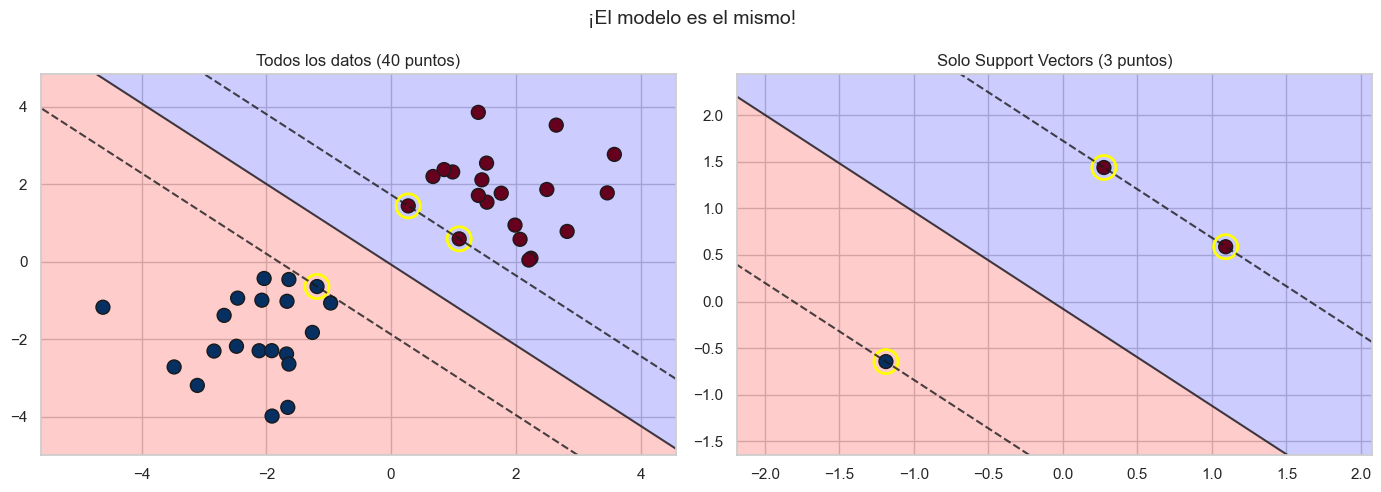

In [4]:
# Demostración: Solo los Support Vectors definen el modelo
# Eliminar puntos que NO son support vectors
sv_indices = svm_linear.support_
X_only_sv = X_simple[sv_indices]
y_only_sv = y_simple[sv_indices]

svm_from_sv = SVC(kernel='linear', C=1000)
svm_from_sv.fit(X_only_sv, y_only_sv)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

plot_svm_decision(svm_linear, X_simple, y_simple, axes[0],
                  f'Todos los datos ({len(X_simple)} puntos)')

plot_svm_decision(svm_from_sv, X_only_sv, y_only_sv, axes[1],
                  f'Solo Support Vectors ({len(X_only_sv)} puntos)')

plt.suptitle('¡El modelo es el mismo!', fontsize=14)
plt.tight_layout()
plt.show()


> **💡 Pro-Tip: Support Vectors y Memoria**
> SVM solo necesita guardar los support vectors para hacer predicciones. Si tienes 1M de datos pero solo 1000 SV, el modelo es compacto.

---

## 4. El Kernel Trick: Magia Dimensional

### El Problema: Datos No Linealmente Separables

¿Qué pasa cuando los datos tienen forma de círculos concéntricos?

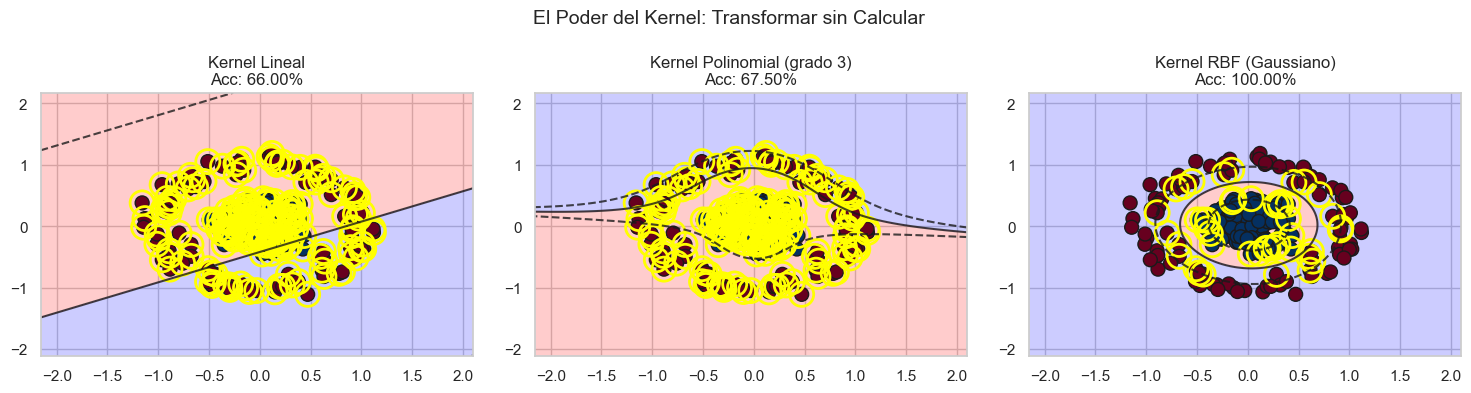

In [5]:
# Datos en forma de círculos
X_circles, y_circles = make_circles(
    n_samples=200, noise=0.1, factor=0.3, random_state=RANDOM_STATE)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Kernel Lineal (falla)
svm_lin = SVC(kernel='linear')
svm_lin.fit(X_circles, y_circles)
plot_svm_decision(svm_lin, X_circles, y_circles, axes[0],
                  f'Kernel Lineal\nAcc: {svm_lin.score(X_circles, y_circles):.2%}')

# Kernel Polinomial
svm_poly = SVC(kernel='poly', degree=3)
svm_poly.fit(X_circles, y_circles)
plot_svm_decision(svm_poly, X_circles, y_circles, axes[1],
                  f'Kernel Polinomial (grado 3)\nAcc: {svm_poly.score(X_circles, y_circles):.2%}')

# Kernel RBF (Gaussiano)
svm_rbf = SVC(kernel='rbf', gamma='auto')
svm_rbf.fit(X_circles, y_circles)
plot_svm_decision(svm_rbf, X_circles, y_circles, axes[2],
                  f'Kernel RBF (Gaussiano)\nAcc: {svm_rbf.score(X_circles, y_circles):.2%}')

plt.suptitle('El Poder del Kernel: Transformar sin Calcular', fontsize=14)
plt.tight_layout()
plt.show()


### ¿Cómo Funciona el Kernel Trick?

**Idea:** Mapear los datos a un espacio de **alta dimensión** donde sean linealmente separables.

**El Truco:** No necesitamos calcular las coordenadas en ese espacio, solo el **producto interno** (kernel).

| Kernel | Fórmula | Uso Típico |
|--------|---------|------------|
| **Lineal** | $K(x,y) = x \cdot y$ | Datos linealmente separables |
| **Polinomial** | $K(x,y) = (x \cdot y + c)^d$ | Interacciones de features |
| **RBF (Gaussiano)** | $K(x,y) = e^{-\gamma ||x-y||^2}$ | Default para no lineal |

```
Espacio Original (2D)        Espacio Transformado (∞D)
    ○ ○ ○                         ○ ○ ○
  ● ○ ○ ○ ●        →        ─────────────
    ○ ○ ○                         ● ● ●
```

---

## 5. SVM en Acción

### Comparación con Dataset "Moons"

In [6]:
# Datos moons
X_moons, y_moons = make_moons(
    n_samples=300, noise=0.2, random_state=RANDOM_STATE)

# Escalar datos (IMPORTANTE para SVM)
scaler = StandardScaler()
X_moons_scaled = scaler.fit_transform(X_moons)

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X_moons_scaled, y_moons, test_size=0.3, random_state=RANDOM_STATE)

# Entrenar SVM RBF
svm_moons = SVC(kernel='rbf', C=1, gamma='scale')
svm_moons.fit(X_train, y_train)

print(f"📊 Train Accuracy: {svm_moons.score(X_train, y_train):.2%}")
print(f"📊 Test Accuracy:  {svm_moons.score(X_test, y_test):.2%}")
print(
    f"📊 Support Vectors: {len(svm_moons.support_vectors_)} de {len(X_train)} ({len(svm_moons.support_vectors_)/len(X_train):.1%})")


📊 Train Accuracy: 92.86%
📊 Test Accuracy:  93.33%
📊 Support Vectors: 66 de 210 (31.4%)


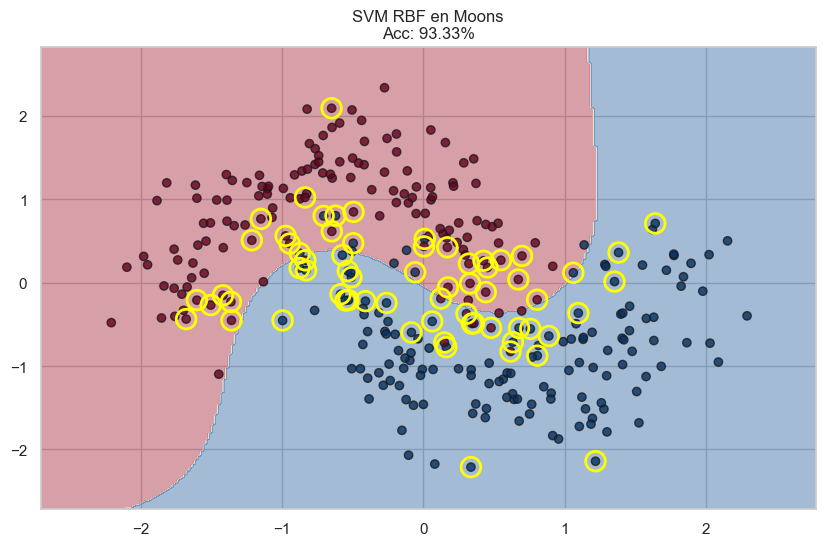

In [7]:
# Visualizar frontera
def plot_svm_full(model, X, y, title):
    h = 0.02
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.4, cmap='RdBu')
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='RdBu', edgecolors='k', alpha=0.8)
    plt.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1],
                s=200, linewidth=2, facecolors='none', edgecolors='yellow')
    plt.title(title)


plt.figure(figsize=(10, 6))
plot_svm_full(svm_moons, X_moons_scaled, y_moons,
              f'SVM RBF en Moons\nAcc: {svm_moons.score(X_test, y_test):.2%}')
plt.show()


> **⚠️ Real-World Warning: ¡Escala tus datos!**
> SVM es MUY sensible a la escala. Si una feature va de 0-1 y otra de 0-1000000, el kernel RBF fallará.
> 
> **Siempre:** `StandardScaler()` antes de SVM.

---

## 6. Hiperparámetros Clave

### Los Dos Parámetros Críticos

| Parámetro | Descripción | Efecto |
|-----------|-------------|--------|
| **C** | Regularización (inverso) | C bajo = margen ancho (tolerante), C alto = margen estrecho (estricto) |
| **gamma** (γ) | Alcance del kernel RBF | γ bajo = influencia amplia, γ alto = influencia local |

```
C bajo + γ bajo = Underfitting (muy simple)
C alto + γ alto = Overfitting (muy complejo)
```

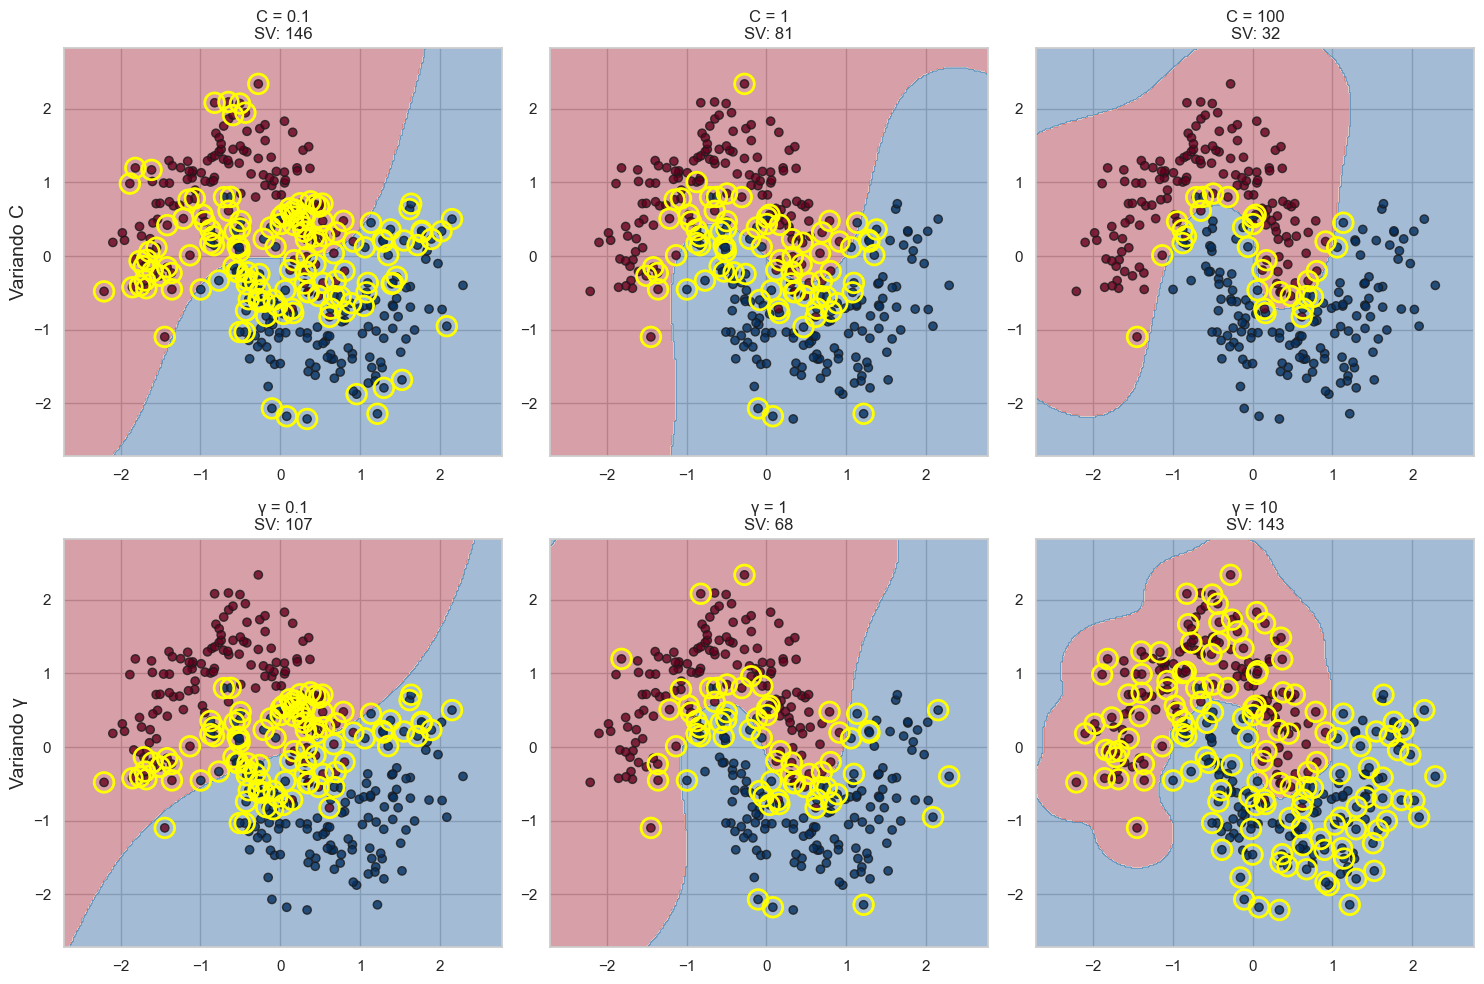

🔍 C alto → Frontera más compleja (menos tolerante a errores)
🔍 γ alto → Puntos solo influyen localmente (frontera dentada)


In [8]:
# Visualizar efecto de C y gamma
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Variar C
for i, C in enumerate([0.1, 1, 100]):
    svm_c = SVC(kernel='rbf', C=C, gamma='scale')
    svm_c.fit(X_moons_scaled, y_moons)
    plt.sca(axes[0, i])
    plot_svm_full(svm_c, X_moons_scaled, y_moons,
                  f'C = {C}\nSV: {len(svm_c.support_vectors_)}')

# Variar gamma
for i, gamma in enumerate([0.1, 1, 10]):
    svm_g = SVC(kernel='rbf', C=1, gamma=gamma)
    svm_g.fit(X_moons_scaled, y_moons)
    plt.sca(axes[1, i])
    plot_svm_full(svm_g, X_moons_scaled, y_moons,
                  f'γ = {gamma}\nSV: {len(svm_g.support_vectors_)}')

axes[0, 0].set_ylabel('Variando C', fontsize=14)
axes[1, 0].set_ylabel('Variando γ', fontsize=14)

plt.tight_layout()
plt.show()

print("🔍 C alto → Frontera más compleja (menos tolerante a errores)")
print("🔍 γ alto → Puntos solo influyen localmente (frontera dentada)")


In [9]:
# Grid Search para encontrar mejores parámetros
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.01, 0.1, 1, 10]
}

grid_search = GridSearchCV(
    SVC(kernel='rbf'), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print(f"📊 Mejores parámetros: {grid_search.best_params_}")
print(f"📊 Mejor CV Score: {grid_search.best_score_:.2%}")
print(f"📊 Test Score: {grid_search.score(X_test, y_test):.2%}")


📊 Mejores parámetros: {'C': 1, 'gamma': 1}
📊 Mejor CV Score: 94.29%
📊 Test Score: 98.89%


---

## 7. Caso de Negocio: Clasificación de Dígitos

SVM históricamente fue muy popular para reconocimiento de dígitos escritos a mano.

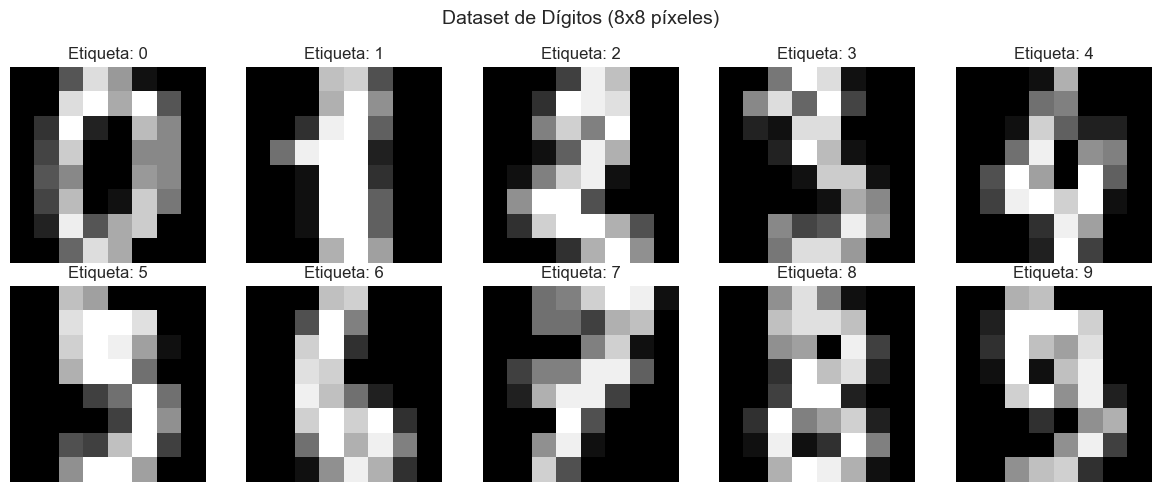

📊 Shape: (1797, 64) (cada imagen es 64 features = 8x8 píxeles)


In [10]:
from sklearn.datasets import load_digits

# Cargar datos
digits = load_digits()
X_digits = digits.data
y_digits = digits.target

# Visualizar algunos ejemplos
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(digits.images[i], cmap='gray')
    ax.set_title(f'Etiqueta: {digits.target[i]}')
    ax.axis('off')
plt.suptitle('Dataset de Dígitos (8x8 píxeles)', fontsize=14)
plt.tight_layout()
plt.show()

print(f"📊 Shape: {X_digits.shape} (cada imagen es 64 features = 8x8 píxeles)")


In [11]:
# Escalar y dividir
scaler = StandardScaler()
X_digits_scaled = scaler.fit_transform(X_digits)

X_tr, X_ts, y_tr, y_ts = train_test_split(
    X_digits_scaled, y_digits, test_size=0.3, stratify=y_digits, random_state=RANDOM_STATE)

# Entrenar SVM
svm_digits = SVC(kernel='rbf', C=10, gamma='scale')
svm_digits.fit(X_tr, y_tr)

print(f"📊 Test Accuracy: {svm_digits.score(X_ts, y_ts):.2%}")
print(
    f"📊 Support Vectors: {len(svm_digits.support_vectors_)} de {len(X_tr)} ({len(svm_digits.support_vectors_)/len(X_tr):.1%})")


📊 Test Accuracy: 97.96%
📊 Support Vectors: 659 de 1257 (52.4%)


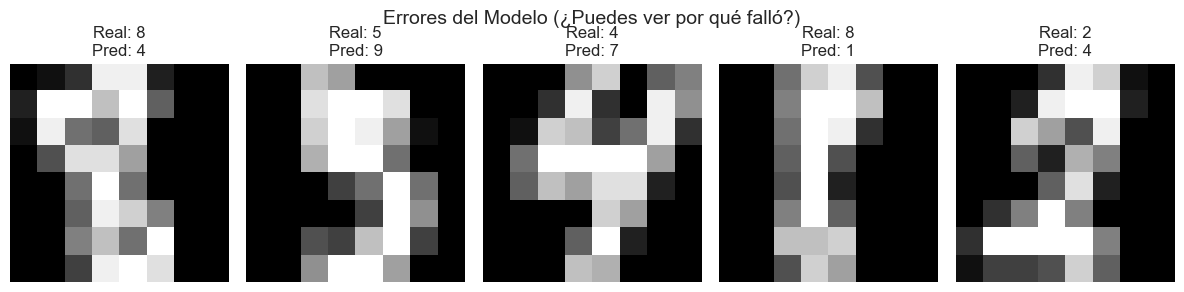

In [12]:
# Ver algunos errores
y_pred = svm_digits.predict(X_ts)
errors = y_pred != y_ts
error_indices = np.where(errors)[0]

if len(error_indices) > 0:
    fig, axes = plt.subplots(1, min(5, len(error_indices)), figsize=(12, 3))
    if len(error_indices) < 5:
        axes = [axes] if len(error_indices) == 1 else axes
    for i, idx in enumerate(error_indices[:5]):
        ax = axes[i]
        ax.imshow(scaler.inverse_transform(
            X_ts[idx:idx+1]).reshape(8, 8), cmap='gray')
        ax.set_title(
            f'Real: {y_ts.iloc[idx] if hasattr(y_ts, "iloc") else y_ts[idx]}\nPred: {y_pred[idx]}')
        ax.axis('off')
    plt.suptitle(
        'Errores del Modelo (¿Puedes ver por qué falló?)', fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    print("🎉 ¡No hay errores en la muestra!")


### 🧠 Micro-Desafío: ¿Por Qué SVM Brilla Aquí?

**Reflexiona:**
1. Los datos están en alta dimensión (64 features)
2. Las clases son relativamente separables
3. El kernel RBF captura patrones no lineales

**Pregunta:** ¿Qué pasaría si las imágenes fueran de 100x100 píxeles?

> **⚠️ Real-World Warning: Escalabilidad**
> SVM tiene complejidad $O(n^2)$ a $O(n^3)$ en memoria y tiempo. Con más de ~50,000 muestras, considera:
> - `LinearSVC` para kernel lineal
> - Reducción de dimensionalidad (PCA)
> - Aproximaciones como `SGDClassifier` con kernel aproximado

---

## 8. Resumen y Siguiente Paso

### 🏆 Resumen de Logros
¡Felicidades! En este notebook has aprendido:

1. **Máximo Margen:** SVM busca el separador con mayor distancia a los puntos más cercanos.
2. **Support Vectors:** Solo los puntos críticos definen el modelo.
3. **Kernel Trick:** Transformar el espacio sin calcular dimensiones infinitas.
4. **C y gamma:** Controlan regularización y alcance del kernel.
5. **Escalado:** Imprescindible para SVM.

### ✅ Cuándo Usar SVM
- Datos de dimensión media-alta (10-1000 features)
- Clases bien separables
- Cuando necesitas un modelo compacto (pocos SV)

### ⚠️ Cuándo Evitar SVM
- Datasets muy grandes (>50k muestras)
- Cuando necesitas probabilidades calibradas
- Features categóricas sin encoding

---

### 👉 Siguiente Paso
SVM busca el mejor separador global. Pero existe un enfoque más simple: **¿Qué hacen tus vecinos más cercanos?**

**KNN (K-Nearest Neighbors):** Clasificar basándose en la votación de los K vecinos más cercanos.

*En el siguiente notebook veremos este algoritmo "lazy" que no entrena, solo recuerda.*